### Data Parsing in R

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
install.packages("Biostrings")

library(Biostrings)

(as ‘lib’ is unspecified)




A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages 




Error in library(Biostrings) : there is no package called ‘Biostrings’


In [ ]:
%%R
#install.packages("R.utils")
#install.packages("mildsvm")
install.packages("e1071")
install.packages("ROSE")


In [ ]:
%%R
library(jsonlite)
library(stringr)
library(R.utils)
library(dplyr)

# gunzip("drive/MyDrive/dataset0.json.gz", remove = F)

df <- bind_rows(lapply(readLines("drive/MyDrive/dataset0.json"), function(line) {
  temp <- as.data.frame(jsonlite::fromJSON(line))
  info <- str_split(colnames(temp)[1], pattern = "\\.")[[1]]
  transcript_id <- info[1]
  pos_no <- info[2]
  sequence <- info[3]
  read_id <- seq(1, nrow(temp))

  temp <- cbind(read_id, transcript_id, pos_no, sequence, temp)
  colnames(temp)[5:13] <- c("dwelling_t-1", "sd_-1", "mean_-1",
                            "dwelling_t0", "sd_0", "mean_0",
                            "dwelling_t1", "sd_1", "mean_1")
  return(temp)
}))

write.csv(df, file = "dataset.csv", row.names = F)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%R
library(tidyverse)

df <- read.csv("drive/MyDrive/dataset.csv")
info <- read.csv("drive/MyDrive/data.info")


In [ ]:
%%R

colnames(df)[3] <- "transcript_position"

full_df <- left_join(df, info, by = c("transcript_id", "transcript_position"))



In [ ]:
%%R

library(mildsvm)

full_df_bag <- full_df %>%
                mutate(id_pos = paste(transcript_id, transcript_position))

fit <- omisvm(mi(label, id_pos) ~ dwelling_t.1 + sd_.1 + mean_.1 + dwelling_t0 + sd_0 + mean_0 + dwelling_t1 + sd_1 + mean_1, data = full_df_bag, weights = NULL)
print(fit)

In [ ]:
%%R

head(full_df)

  read_id   transcript_id transcript_position sequence dwelling_t.1 sd_.1
1       1 ENST00000000233                 244  AAGACCA      0.00299  2.06
2       2 ENST00000000233                 244  AAGACCA      0.00631  2.53
3       3 ENST00000000233                 244  AAGACCA      0.00465  3.92
4       4 ENST00000000233                 244  AAGACCA      0.00398  2.06
5       5 ENST00000000233                 244  AAGACCA      0.00664  2.92
6       6 ENST00000000233                 244  AAGACCA      0.01030  3.83
  mean_.1 dwelling_t0  sd_0 mean_0 dwelling_t1  sd_1 mean_1         gene_id
1     125     0.01770 10.40    122     0.00930 10.90   84.1 ENSG00000004059
2     125     0.00844  4.67    126     0.01030  6.30   80.9 ENSG00000004059
3     109     0.01360 12.00    124     0.00498  2.13   79.6 ENSG00000004059
4     125     0.00830  5.01    130     0.00498  3.78   80.4 ENSG00000004059
5     120     0.00266  3.94    129     0.01300  7.15   82.2 ENSG00000004059
6     123     0.00598  6.4

In [ ]:
%%R

full_df %>%
  mutate(label = as.factor(label)) %>%
  group_by(transcript_id, transcript_position, gene_id, label) %>%
  summarise(across(`dwelling_t.1`:mean_1, mean)) -> agg_full_df

`summarise()` has grouped output by 'transcript_id', 'transcript_position',
'gene_id'. You can override using the `.groups` argument.


In [ ]:
%%R

sample <- full_df[1:20000,]
sample %>%
  group_by(transcript_id, transcript_position, gene_id, label) %>%
  summarise(across(`dwelling_t.1`:mean_1, mean)) -> agg_full_df

`summarise()` has grouped output by 'transcript_id', 'transcript_position',
'gene_id'. You can override using the `.groups` argument.


In [ ]:
%%R

gene_set <- unique(agg_full_df$gene_id)
n_gene <- length(gene_set)

train_set <- sample(1:n_gene, floor(0.7*n_gene))
train_gene <- gene_set[train_set]

df_train <- agg_full_df %>%
              filter(gene_id %in% train_gene)
df_test <- agg_full_df %>%
              filter(!(gene_id %in% train_gene))



In [ ]:
%%R

head(agg_full_df)

In [ ]:
%%R

library(e1071)

svm_model<- svm(label ~ `dwelling_t.1` + `sd_.1` + `mean_.1` + dwelling_t0 + sd_0 + mean_0 + dwelling_t1 + sd_1 + mean_1,
                data = df_train,
                type = "C-classification",
                kernel = "polynomial",
                scale = FALSE)

In [ ]:
%%R
library(ROSE)
library(e1071)

syn_data <- ROSE(label~., data = df_train[,4:13])$data
table(syn_data$label)

svm_model<- svm(label ~ `dwelling_t.1` + `sd_.1` + `mean_.1` + dwelling_t0 + sd_0 + mean_0 + dwelling_t1 + sd_1 + mean_1,
                data = syn_data,
                type = "C-classification",
                kernel = "polynomial",
                scale = FALSE)

In [ ]:
%%R

pred_test <- predict(svm_model, df_test)
roc.curve(df_test$label, pred_test, plotit = T)
#accuracy.meas(df_test$label, pred_test)


In [ ]:
%%R

agg_full_df %>%
  filter(label == 0) %>%
  mutate(id_pos = paste(transcript_id, transcript_position)) %>%
  .$id_pos %>%
  unique() %>%
  length()

[1] 116363


In [ ]:
%%R

library(ROSE)
library(rpart)

treeimb <- rpart(cls ~., data = hacide.train)
pred.treeimb <- predict(treeimb, newdata = hacide.test)

?roc.curve

In [ ]:
%%R

head(df_train)

# A tibble: 6 × 13
# Groups:   transcript_id, transcript_position, gene_id [6]
  transcript_id   transcript_position gene_id   label dwelling_t.1 sd_.1 mean_.1
  <chr>                         <int> <chr>     <fct>        <dbl> <dbl>   <dbl>
1 ENST00000000233                 244 ENSG0000… 0          0.00826  4.22    124.
2 ENST00000000233                 261 ENSG0000… 0          0.00661  3.22    110.
3 ENST00000000233                 316 ENSG0000… 0          0.00757  2.94    105.
4 ENST00000000233                 332 ENSG0000… 0          0.0106   6.48    129.
5 ENST00000000233                 368 ENSG0000… 0          0.0107   6.42    118.
6 ENST00000000233                 404 ENSG0000… 0          0.00901  6.39    128.
# ℹ 6 more variables: dwelling_t0 <dbl>, sd_0 <dbl>, mean_0 <dbl>,
#   dwelling_t1 <dbl>, sd_1 <dbl>, mean_1 <dbl>


# Data Parsing in Python

In [ ]:
import pandas as pd
import numpy as np
import gzip
import json

def parse_data(info_path, json_zip_path):
   # loads data
   print(f"Loading {json_zip_path}...")
   with gzip.open(json_zip_path, "r") as f:
      data = [json.loads(line) for line in f]

   # loads data with label
   print(f"Loading {info_path}...")
   info = pd.read_csv(info_path)

   #transfer information from json dict to list
   print("Transferring data from json to dataframe...")
   res = []
   for row in data:
      for trans_id in row.keys():
         for trans_pos in row[trans_id].keys():
            for nucleo_seq in row[trans_id][trans_pos].keys():
               temp = list(np.mean(np.array(row[trans_id][trans_pos][nucleo_seq]), axis=0))
               # to get raw data without aggregation
               # for features in row[trans_id][trans_pos][nucleo_seq]:
               res.append([trans_id, int(trans_pos), nucleo_seq] + temp)

   data = pd.DataFrame(res, columns = ['transcript_id', 'transcript_position', 'sequence',
                                       'dwelling_t-1', 'sd_-1', 'mean_-1',
                                       'dwelling_t0', 'sd_0', 'mean_0',
                                       'dwelling_t1', 'sd_1', 'mean_1'
                                       ])
   # Merge json data with labels
   print("Merging dataframes to obtain labels")
   merged_data = pd.merge(data,info, on = ['transcript_id', 'transcript_position'])

   return merged_data


In [ ]:
df = parse_data("/Users/shaun/Desktop/DSA4266/project2/data.info",'/Users/shaun/Desktop/DSA4266/project2/dataset0.json.gz')

# Feature engineering/Data cleaning

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("drive/MyDrive/merged_data.csv").iloc[:,2:17]
df

,transcript_id,pos_no,sequence,dwelling_t-1,sd_-1,mean_-1,dwelling_t0,sd_0,mean_0,dwelling_t1,sd_1,mean_1,gene_id,transcript_position,label
0,ENST00000000233,244,AAGACCA,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.1,ENSG00000004059,244,0
1,ENST00000000233,244,AAGACCA,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.9,ENSG00000004059,244,0
2,ENST00000000233,244,AAGACCA,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.6,ENSG00000004059,244,0
3,ENST00000000233,244,AAGACCA,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.4,ENSG00000004059,244,0
4,ENST00000000233,244,AAGACCA,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.2,ENSG00000004059,244,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11027101,ENST00000641834,1693,TTGACAT,0.00418,7.49,108.0,0.00564,10.20,116.0,0.01000,2.01,76.4,ENSG00000167747,1693,0
11027102,ENST00000641834,1693,TTGACAT,0.00664,1.91,109.0,0.00598,12.30,110.0,0.01760,2.61,74.6,ENSG00000167747,1693,0
11027103,ENST00000641834,1693,TTGACAT,0.00721,4.58,105.0,0.00398,6.58,113.0,0.00316,2.28,85.3,ENSG00000167747,1693,0
11027104,ENST00000641834,1693,TTGACAT,0.00266,2.33,109.0,0.00913,10.40,108.0,0.00664,4.44,76.8,ENSG00000167747,1693,0


In [ ]:
! pip install category_encoders

In [3]:
import category_encoders as ce

new_df = df.groupby(['transcript_id', 'transcript_position', 'gene_id', 'label', 'sequence']).mean(['dwelling_t-1', 'sd_-1', 'mean_-1',
                                                           'dwelling_t0', 'sd_0', 'mean_0',
                                                           'dwelling_t1', 'sd_1', 'mean_1']).reset_index().drop('pos_no', axis = 1)
new_df['transcript_id'] = new_df['transcript_id'].str.split('T').str[1].astype(int)
new_df['gene_id'] = new_df['gene_id'].str.split('G').str[1].astype(int)

encoder = ce.OneHotEncoder(use_cat_names=True)
new_df = pd.concat([new_df, encoder.fit_transform(new_df['sequence'].str.split('', expand = True)[[1, 2, 3, 5, 6, 7]].rename(columns = {3: 'nucleo_-1', 5: 'nucleo_1',
                                                                                                         1: 'nucleo_-3', 2: 'nucleo_-2',
                                                                                                         6: 'nucleo_2', 7: 'nucleo_3'}))], axis = 1)

new_df

,transcript_id,transcript_position,gene_id,label,sequence,dwelling_t-1,sd_-1,mean_-1,dwelling_t0,sd_0,...,nucleo_-1_G,nucleo_-1_A,nucleo_1_C,nucleo_2_C,nucleo_2_T,nucleo_2_A,nucleo_3_A,nucleo_3_G,nucleo_3_T,nucleo_3_C
0,233,244,4059,0,AAGACCA,0.008264,4.223784,123.702703,0.009373,7.382162,...,1,0,1,1,0,0,1,0,0,0
1,233,261,4059,0,CAAACTG,0.006609,3.216424,109.681395,0.006813,3.226535,...,0,1,1,0,1,0,0,1,0,0
2,233,316,4059,0,GAAACAG,0.007570,2.940541,105.475676,0.007416,3.642703,...,0,1,1,0,0,1,0,1,0,0
3,233,332,4059,0,AGAACAT,0.010620,6.476350,129.355000,0.008632,2.899200,...,0,1,1,0,0,1,0,0,1,0
4,233,368,4059,0,AGGACAA,0.010701,6.415051,117.924242,0.011479,5.870303,...,1,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,641834,1348,167747,1,GGGACAT,0.009594,3.294164,118.232877,0.007300,4.929726,...,1,0,1,0,0,1,0,0,1,0
121834,641834,1429,167747,0,CTGACAC,0.008393,4.511014,110.969565,0.010305,9.105797,...,1,0,1,0,0,1,0,0,0,1
121835,641834,1531,167747,1,TGGACAC,0.008161,3.918438,113.968750,0.006877,4.759688,...,1,0,1,0,0,1,0,0,0,1
121836,641834,1537,167747,0,CTGACCA,0.008044,3.191228,109.354386,0.007419,6.552982,...,1,0,1,1,0,0,1,0,0,0


In [20]:
new_df.columns

Index(['transcript_id', 'transcript_position', 'gene_id', 'label',
       'dwelling_t-1', 'sd_-1', 'mean_-1', 'dwelling_t0', 'sd_0', 'mean_0',
       'dwelling_t1', 'sd_1', 'mean_1', 'nucleo_-3_A', 'nucleo_-3_C',
       'nucleo_-3_G', 'nucleo_-3_T', 'nucleo_-2_A', 'nucleo_-2_G',
       'nucleo_-2_T', 'nucleo_-1_G', 'nucleo_-1_A', 'nucleo_1_C', 'nucleo_2_C',
       'nucleo_2_T', 'nucleo_2_A', 'nucleo_3_A', 'nucleo_3_G', 'nucleo_3_T',
       'nucleo_3_C', 'pwm_score', '5mer_-1', '5mer_0', '5mer_1', 'knf_AA',
       'knf_AG', 'knf_AT', 'knf_AC', 'knf_GG', 'knf_GA', 'knf_GT', 'knf_GC',
       'knf_TT', 'knf_TA', 'knf_TG', 'knf_TC', 'knf_CC', 'knf_CA', 'knf_CT',
       'knf_CG', 'cksnap_AA', 'cksnap_AG', 'cksnap_AT', 'cksnap_AC',
       'cksnap_GG', 'cksnap_GA', 'cksnap_GT', 'cksnap_GC', 'cksnap_TT',
       'cksnap_TA', 'cksnap_TG', 'cksnap_TC', 'cksnap_CC', 'cksnap_CA',
       'cksnap_CT', 'cksnap_CG', 'dacc_bet', 'js_all'],
      dtype='object')

In [4]:
import numpy as np

def kmers(sequence, ksize=5):
    kmers = []
    n_kmers = len(sequence) - ksize + 1

    for i in range(n_kmers):
        kmer = sequence[i:i + ksize]
        kmers.append(kmer)

    return kmers

def create_pwm_from_sequences(sequences):
    """
    Create a Position Weight Matrix (PWM) from a list of sequences.

    Args:
        sequences (list of str): List of DNA sequences of equal length.

    Returns:
        np.ndarray: The PWM matrix.
    """
    # Check if all sequences have the same length
    seq_length = len(sequences[0])
    if not all(len(seq) == seq_length for seq in sequences):
        raise ValueError("All sequences must have the same length")

    # Initialize the PWM matrix with zeros
    pwm = np.zeros((4, seq_length))  # 4 rows for A, C, G, T

    # Count the occurrences of each nucleotide at each position
    for seq in sequences:
        for i, nucleotide in enumerate(seq):
            if nucleotide == 'A':
                pwm[0, i] += 1
            elif nucleotide == 'C':
                pwm[1, i] += 1
            elif nucleotide == 'G':
                pwm[2, i] += 1
            elif nucleotide == 'T':
                pwm[3, i] += 1

    # Convert counts to probabilities
    pwm = pwm / len(sequences)

    return pd.DataFrame(data=pwm, columns=[1,2,3,4,5,6,7], index=["A","C","G","T"])

def log_odds(x):
    """
    Function to calculate log odds
    """
    if x == 0:
        return 0
    else:
        return np.log2(x/0.25)


def get_log_odds(sequences):
    """To get log odd dictionary which is used to calculate PWM score for each nucleo_seq"""
    ppm = create_pwm_from_sequences(sequences)
    log_odds_pos = ppm.applymap(log_odds)
    log_odds_dict = log_odds_pos.to_dict()

    return log_odds_dict, ppm


def get_PWM_score(seq):
    """Calculating PWM score for nucleo_seq based on the log odds"""
    res = 0
    for i in range(len(seq)):
        base = seq[i]
        dic = log_odds_dict[(i+1)]
        res = res + dic[base]
    return res

index_ls = ["AA", "AG", "AT", "AC", "GG", "GA", "GT", "GC", "TT", "TA", "TG", "TC", "CC", "CA", "CT", "CG"]

def get_knf(seq, k, prob = True, output_dic = True):
  dic = {}
  n_kmers = len(seq) - k + 1
  for i in range(n_kmers):
    kmer = seq[i: i + k]
    if kmer not in dic:
      dic[kmer] = 0
    dic[kmer] += 1
  if prob != True:
    return dic
  if output_dic != True:
    ls = np.zeros(len(index_ls))
    for k, v in dic.items():
      ls[index_ls.index(k)] = v
    return ls/n_kmers
  return {k: v/n_kmers for k, v in dic.items()}

def get_cksnap(seq, k, output_dic = True):
  dic = {}
  n_ks_mers = len(seq) - k - 1
  for i in range(n_ks_mers):
    kmer = seq[i: i + k + 2]
    ks_mer = kmer[0] + kmer[-1]
    if ks_mer not in dic:
      dic[ks_mer] = 0
    dic[ks_mer] += 1
  if output_dic != True:
    ls = np.zeros(len(index_ls))
    for k, v in dic.items():
      ls[index_ls.index(k)] = v
    return ls/n_ks_mers
  return {k: v/n_ks_mers for k, v in dic.items()}

def dacc(seq1, seq2):
  acc = 0
  seq1_knf = get_knf(seq1, 2, False)
  seq2_knf = get_knf(seq2, 2, False)
  for i in range(len(seq1) - 3):
    acc += seq1_knf[seq1[i:i+2]]*seq2_knf[seq2[i+2: i+4]] + seq1_knf[seq1[i+2: i+4]]*seq2_knf[seq2[i:i+2]]
  return acc



def jaccard_similarity(kmer_ls, sliced):
    a = set(get_knf(kmer_ls[0], sliced, False))
    b = set(get_knf(kmer_ls[1], sliced, False))
    c = set(get_knf(kmer_ls[2], sliced, False))
    intersection_ab = len(a.intersection(b))
    union_ab = len(a.union(b))
    intersection_ac = len(a.intersection(c))
    union_ac = len(a.union(c))
    intersection_bc = len(b.intersection(c))
    union_bc = len(b.union(c))

    return (intersection_ab/union_ab + intersection_ac/union_ac + intersection_bc/union_bc)/3

In [5]:
# with position features

log_odds_dict, ppm = get_log_odds(new_df.sequence)
new_df["pwm_score"] = new_df.apply(lambda x: get_PWM_score(x.sequence),axis=1)
new_df[["5mer_-1", "5mer_0", "5mer_1"]] = new_df['sequence'].apply(lambda x: list(get_knf(x, 5))).apply(pd.Series)
new_df[["knf_" + i for i in index_ls]] = new_df['sequence'].apply(lambda x: get_knf(x, 2, output_dic = False)).apply(pd.Series)
new_df[["cksnap_" + i for i in index_ls]] = new_df['sequence'].apply(lambda x: get_cksnap(x, 2, output_dic = False)).apply(pd.Series)
new_df['dacc_bet'] = new_df['sequence'].apply(lambda x: dacc(list(get_knf(x, 5))[0], list(get_knf(x, 5))[2]))
new_df['js_all'] = new_df['sequence'].apply(lambda x: jaccard_similarity(list(get_knf(x, 5)), 2))

#new_df = pd.get_dummies(new_df, columns = ['nucleo_-3', 'nucleo_-2', 'nucleo_-1', 'nucleo_1', 'nucleo_2', 'nucleo_3']).drop(columns = 'sequence')

new_df = new_df.drop(columns = ['sequence'])
new_df

,transcript_id,transcript_position,gene_id,label,dwelling_t-1,sd_-1,mean_-1,dwelling_t0,sd_0,mean_0,...,cksnap_TT,cksnap_TA,cksnap_TG,cksnap_TC,cksnap_CC,cksnap_CA,cksnap_CT,cksnap_CG,dacc_bet,js_all
0,233,244,4059,0,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,4,0.511111
1,233,261,4059,0,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,...,0.0,0.00,0.0,0.00,0.0,0.25,0.0,0.0,6,0.550000
2,233,316,4059,0,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,6,0.550000
3,233,332,4059,0,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,4,0.511111
4,233,368,4059,0,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,4,0.511111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,641834,1348,167747,1,0.009594,3.294164,118.232877,0.007300,4.929726,116.342466,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,6,0.583333
121834,641834,1429,167747,0,0.008393,4.511014,110.969565,0.010305,9.105797,114.927536,...,0.0,0.00,0.0,0.25,0.0,0.25,0.0,0.0,6,0.583333
121835,641834,1531,167747,1,0.008161,3.918438,113.968750,0.006877,4.759688,113.562500,...,0.0,0.25,0.0,0.00,0.0,0.00,0.0,0.0,6,0.583333
121836,641834,1537,167747,0,0.008044,3.191228,109.354386,0.007419,6.552982,123.263158,...,0.0,0.00,0.0,0.25,0.0,0.25,0.0,0.0,4,0.511111


In [6]:
features = [
       'dwelling_t-1', 'sd_-1', 'mean_-1', 'dwelling_t0', 'sd_0', 'mean_0',
       'dwelling_t1', 'sd_1', 'mean_1', 'nucleo_-3_A', 'nucleo_-3_C',
       'nucleo_-3_G', 'nucleo_-3_T', 'nucleo_-2_A', 'nucleo_-2_G',
       'nucleo_-2_T', 'nucleo_-1_G', 'nucleo_-1_A', 'nucleo_1_C', 'nucleo_2_C',
       'nucleo_2_T', 'nucleo_2_A', 'nucleo_3_A', 'nucleo_3_G', 'nucleo_3_T',
       'nucleo_3_C', 'pwm_score', 'knf_AA',
       'knf_AG', 'knf_AT', 'knf_AC', 'knf_GG', 'knf_GA', 'knf_GT', 'knf_GC',
       'knf_TT', 'knf_TA', 'knf_TG', 'knf_TC', 'knf_CC', 'knf_CA', 'knf_CT',
       'knf_CG', 'cksnap_AA', 'cksnap_AG', 'cksnap_AT', 'cksnap_AC',
       'cksnap_GG', 'cksnap_GA', 'cksnap_GT', 'cksnap_GC', 'cksnap_TT',
       'cksnap_TA', 'cksnap_TG', 'cksnap_TC', 'cksnap_CC', 'cksnap_CA',
       'cksnap_CT', 'cksnap_CG', 'dacc_bet', 'js_all']

identifier = ["transcript_id", "transcript_position", "gene_id", "label"]

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
new_df_scaled = pd.DataFrame(scaler.fit_transform(new_df[features]), columns = new_df[features].columns)
new_df_scaled = pd.concat([new_df[identifier], new_df_scaled], axis=1)
new_df_scaled

,transcript_id,transcript_position,gene_id,label,dwelling_t-1,sd_-1,mean_-1,dwelling_t0,sd_0,mean_0,...,cksnap_TT,cksnap_TA,cksnap_TG,cksnap_TC,cksnap_CC,cksnap_CA,cksnap_CT,cksnap_CG,dacc_bet,js_all
0,233,244,4059,0,0.087761,-0.061120,1.143835,0.736128,1.018569,1.201206,...,0.0,-0.556727,0.0,-0.620949,0.0,-0.476490,0.0,0.0,-0.629935,-0.717202
1,233,261,4059,0,-0.838615,-0.581380,-0.098145,-0.776592,-0.884139,-0.245319,...,0.0,-0.556727,0.0,-0.620949,0.0,2.098679,0.0,0.0,0.249807,-0.315018
2,233,316,4059,0,-0.300881,-0.723863,-0.470680,-0.420555,-0.693591,-0.963005,...,0.0,-0.556727,0.0,-0.620949,0.0,-0.476490,0.0,0.0,0.249807,-0.315018
3,233,332,4059,0,1.406338,1.102240,1.644505,0.298358,-1.034013,-1.052131,...,0.0,-0.556727,0.0,-0.620949,0.0,-0.476490,0.0,0.0,-0.629935,-0.717202
4,233,368,4059,0,1.451257,1.070582,0.631990,1.980413,0.326344,0.883477,...,0.0,-0.556727,0.0,-0.620949,0.0,-0.476490,0.0,0.0,-0.629935,-0.717202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,641834,1348,167747,1,0.831856,-0.541231,0.659329,-0.489046,-0.104311,0.433076,...,0.0,-0.556727,0.0,-0.620949,0.0,-0.476490,0.0,0.0,0.249807,0.029712
121834,641834,1429,167747,0,0.159612,0.087224,0.015958,1.286766,1.807757,0.319520,...,0.0,-0.556727,0.0,1.610438,0.0,2.098679,0.0,0.0,0.249807,0.029712
121835,641834,1531,167747,1,0.029691,-0.218819,0.281620,-0.738890,-0.182165,0.209968,...,0.0,1.796212,0.0,-0.620949,0.0,-0.476490,0.0,0.0,0.249807,0.029712
121836,641834,1537,167747,0,-0.035663,-0.594393,-0.127111,-0.418215,0.638918,0.988500,...,0.0,-0.556727,0.0,1.610438,0.0,2.098679,0.0,0.0,-0.629935,-0.717202


In [ ]:
# without position features
#
#new_df = df.groupby(['transcript_id', 'transcript_position', 'gene_id', 'label']).mean(['dwelling_t-1', 'sd_-1', 'mean_-1',
#                                                           'dwelling_t0', 'sd_0', 'mean_0',
#                                                           'dwelling_t1', 'sd_1', 'mean_1']).reset_index().drop('pos_no', axis = 1)
#new_df['transcript_id'] = new_df['transcript_id'].str.split('T').str[1].astype(int)
#new_df['gene_id'] = new_df['gene_id'].str.split('G').str[1].astype(int)
#
#
#new_df.head(10)

,transcript_id,transcript_position,gene_id,label,dwelling_t-1,sd_-1,mean_-1,dwelling_t0,sd_0,mean_0,dwelling_t1,sd_1,mean_1
0,233,244,4059,0,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,0.007345,4.386989,80.570270
1,233,261,4059,0,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,0.007710,3.016599,94.290698
2,233,316,4059,0,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,0.007555,2.087146,89.364324
3,233,332,4059,0,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,0.006101,2.236520,89.154000
4,233,368,4059,0,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,0.010019,4.260253,85.178788
5,233,404,4059,0,0.009011,6.385260,128.046875,0.008555,2.938281,96.858333,0.005798,2.056797,91.591146
6,233,431,4059,0,0.008683,3.348642,116.864198,0.007249,5.648333,121.345679,0.007839,2.731636,85.971605
7,233,440,4059,0,0.006788,4.521182,96.130542,0.008527,9.343350,119.669951,0.007414,3.505099,81.061084
8,233,471,4059,0,0.006060,8.128495,120.597087,0.006997,3.058350,101.607282,0.006358,1.938034,92.542233
9,233,539,4059,0,0.011070,5.953696,116.989130,0.008996,7.052391,119.538043,0.006398,3.482826,81.005978


# Resampling techniques

In [8]:
from imblearn.over_sampling import SMOTE
import random
import math

gene_set = new_df_scaled['gene_id'].unique()
n_gene = len(gene_set)

train_set = random.sample(range(0, n_gene), math.floor(0.7*n_gene))
train_gene = gene_set[train_set]

df_train = new_df_scaled[new_df_scaled['gene_id'].isin(train_gene)]
df_test = new_df_scaled[~(new_df_scaled['gene_id'].isin(train_gene))]

# comment everything below to not do resampling

#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X = df_train.drop(columns = 'label')
#y = df_train.loc[:,'label']
#X_resampled, y_resampled = smote.fit_resample(X, y)
#df_train = pd.concat([X_resampled, y_resampled], axis=1)



In [30]:
from imblearn.over_sampling import ADASYN
import random
import math

gene_set = new_df_scaled['gene_id'].unique()
n_gene = len(gene_set)

train_set = random.sample(range(0, n_gene), math.floor(0.7*n_gene))
train_gene = gene_set[train_set]

df_train = new_df_scaled[new_df_scaled['gene_id'].isin(train_gene)]
df_test = new_df_scaled[~(new_df_scaled['gene_id'].isin(train_gene))]

adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X = df_train.drop(columns = 'label')
y = df_train.loc[:,'label']
X_resampled, y_resampled = adasyn.fit_resample(X, y)
df_train = pd.concat([X_resampled, y_resampled], axis=1)




In [31]:
df_train['label'].value_counts()

0    79917
1    79844
Name: label, dtype: int64

In [35]:
df_test['label'].value_counts()

0    36077
1     1632
Name: label, dtype: int64

In [42]:
from imblearn.combine import SMOTETomek
import random
import math

gene_set = new_df_scaled['gene_id'].unique()
n_gene = len(gene_set)

train_set = random.sample(range(0, n_gene), math.floor(0.7*n_gene))
train_gene = gene_set[train_set]

df_train = new_df_scaled[new_df_scaled['gene_id'].isin(train_gene)]
df_test = new_df_scaled[~(new_df_scaled['gene_id'].isin(train_gene))]

smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42)
X = df_train.drop(columns = 'label')
y = df_train.loc[:,'label']
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
df_train = pd.concat([X_resampled, y_resampled], axis=1)




In [22]:
from imblearn.combine import SMOTEENN
import random
import math

gene_set = new_df_scaled['gene_id'].unique()
n_gene = len(gene_set)

train_set = random.sample(range(0, n_gene), math.floor(0.7*n_gene))
train_gene = gene_set[train_set]

df_train = new_df_scaled[new_df_scaled['gene_id'].isin(train_gene)]
df_test = new_df_scaled[~(new_df_scaled['gene_id'].isin(train_gene))]

smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
X = df_train.drop(columns = 'label')
y = df_train.loc[:,'label']
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
df_train = pd.concat([X_resampled, y_resampled], axis=1)


Accuracy: 0.9617442266849477
Recall: 0.3434011818778726
AUC: 0.6657719033793691


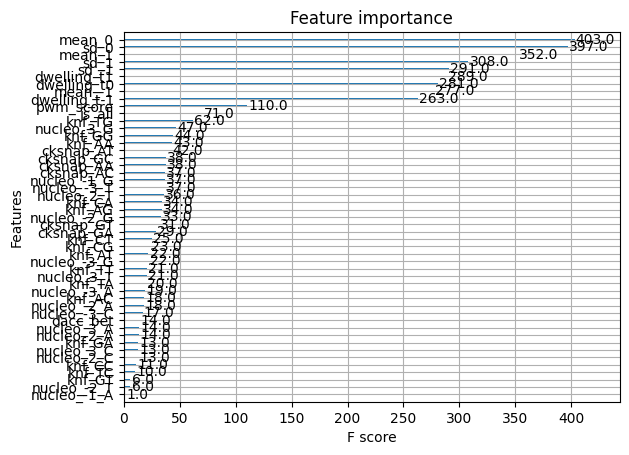

<Figure size 1600x1200 with 0 Axes>

In [23]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


X_train = df_train.drop(columns = ['label', 'gene_id', 'transcript_id', 'transcript_position'])
y_train = df_train.loc[:,'label']
X_test = df_test.drop(columns = ['label', 'gene_id', 'transcript_id', 'transcript_position'])
y_test = df_test.loc[:,'label']

clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Recall:", recall)
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)


xgb.plot_importance(clf)
plt.figure(figsize = (16, 12))
plt.show()

**AUC**

XGBoost: 0.62139238

SMOTE with XGBoost: 0.7637091

ADASYN with XGBoost: 0.76197441

SMOTE + Tomek with XGBoost: 0.7579971

SMOTE + ENN with XGBoost: 0.766277

**Recall**

XGBoost: 0.2441574

SMOTE with XGBoost: 0.602808

ADASYN with XGBoost: 0.6107099

SMOTE + Tomek with XGBoost: 0.62368257

SMOTE + ENN with XGBoost: 0.6303939

**AUC with position features**

XGBoost: 0.638654

SMOTE with XGBoost: 0.6614435

ADASYN with XGBoost: 0.6621789

SMOTE + Tomek with XGBoost: 0.6648953

SMOTE + ENN with XGBoost: 0.673170710

### AUC with all newly added features

XGBoost: 0.6281466721747095

SMOTE with XGBoost: 0.663617396

ADASYN with XGBoost: 0.6742077444

SMOTE + Tomek with XGBoost: 0.6667479

SMOTE + ENN with XGBoost: 0.6769466

### AUC with all features (PWM included) and scaled

XGBoost: 0.6524985519126574

SMOTE with XGBoost: 0.6570264836715892

ADASYN with XGBoost: 0.6663180063250498

SMOTE + Tomek with XGBoost: 0.6607734805850595

SMOTE + ENN with XGBoost: 0.6703012363680388

In [24]:
df_train['label'].value_counts().values[0]/df_train['label'].value_counts().values[1]

1.015185939813254

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

min_features_to_select = 1


X_train = df_train.drop(columns = ['label', 'gene_id', 'transcript_id', 'transcript_position'])
y_train = df_train.loc[:,'label']
X_test = df_test.drop(columns = ['label', 'gene_id', 'transcript_id', 'transcript_position'])
y_test = df_test.loc[:,'label']

# To account for weight imbalances
scale_pos_weight = math.sqrt(df_train['label'].value_counts().values[0]/df_train['label'].value_counts().values[1])

# create a XGB model
clf_xgb = xgb.XGBClassifier(random_state=4266, use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)

# Recursively eliminate features with cross validation
rfecv = RFECV(estimator=clf_xgb, cv=5, scoring='roc_auc', n_jobs=-1, verbose=10, step=1, min_features_to_select= min_features_to_select)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)



In [33]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True, False, False, False,
       False, False, False, False, False,  True,  True])

In [34]:
X_train_new = X_train.iloc[:, rfecv.support_]
X_train_new.columns

Index(['dwelling_t-1', 'sd_-1', 'mean_-1', 'dwelling_t0', 'sd_0', 'mean_0',
       'dwelling_t1', 'sd_1', 'mean_1', 'nucleo_-3_A', 'nucleo_-3_C',
       'nucleo_-3_G', 'nucleo_-3_T', 'nucleo_-2_A', 'nucleo_-2_G',
       'nucleo_-2_T', 'nucleo_-1_G', 'nucleo_-1_A', 'nucleo_2_C', 'nucleo_2_T',
       'nucleo_2_A', 'nucleo_3_A', 'nucleo_3_G', 'nucleo_3_T', 'nucleo_3_C',
       'pwm_score', 'knf_AA', 'knf_AG', 'knf_AT', 'knf_AC', 'knf_GG', 'knf_GA',
       'knf_GT', 'knf_TT', 'knf_TA', 'knf_TG', 'knf_TC', 'knf_CC', 'knf_CA',
       'knf_CT', 'knf_CG', 'cksnap_AA', 'cksnap_AT', 'cksnap_AC', 'cksnap_GA',
       'cksnap_GT', 'cksnap_GC', 'dacc_bet', 'js_all'],
      dtype='object')

In [35]:
rfecv_features= ['dwelling_t-1', 'sd_-1', 'mean_-1', 'dwelling_t0', 'sd_0', 'mean_0',
       'dwelling_t1', 'sd_1', 'mean_1', 'nucleo_-3_A', 'nucleo_-3_C',
       'nucleo_-3_G', 'nucleo_-3_T', 'nucleo_-2_A', 'nucleo_-2_G',
       'nucleo_-2_T', 'nucleo_-1_G', 'nucleo_-1_A', 'nucleo_2_C', 'nucleo_2_T',
       'nucleo_2_A', 'nucleo_3_A', 'nucleo_3_G', 'nucleo_3_T', 'nucleo_3_C',
       'pwm_score', 'knf_AA', 'knf_AG', 'knf_AT', 'knf_AC', 'knf_GG', 'knf_GA',
       'knf_GT', 'knf_TT', 'knf_TA', 'knf_TG', 'knf_TC', 'knf_CC', 'knf_CA',
       'knf_CT', 'knf_CG', 'cksnap_AA', 'cksnap_AT', 'cksnap_AC', 'cksnap_GA',
       'cksnap_GT', 'cksnap_GC', 'dacc_bet', 'js_all']

In [36]:
# To account for weight imbalances
scale_pos_weight = math.sqrt(df_train['label'].value_counts().values[0]/df_train['label'].value_counts().values[1])

# create a XGB model
clf_xgb = xgb.XGBClassifier(random_state=4266, use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)

clf_xgb.fit(X_train_new,y_train)
X_test_new = X_test.loc[:, rfecv_features]

y_pred = clf_xgb.predict(X_test_new)
y_pred_proba = clf_xgb.predict_proba(X_test_new)
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
ap = average_precision_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.9582984949832776
AUC-ROC: 0.8879178570177104
PR-ROC: 0.43902395260966864


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

X_train = df_train.drop(columns = 'label')
y_train = df_train.loc[:,'label']
X_test = df_test.drop(columns = 'label')
y_test = df_test.loc[:,'label']

clf = xgb.XGBClassifier(random_state=4266, colsample_bytree = 0.8, colsample_bynode = 0.8, colsample_bylevel = 0.8, use_label_encoder = False,
                        eval_metric = "logloss", objective = "binary:logistic", n_estimators = 200)

params = {
 "learning_rate" : [0.03, 0.05, 0.08],
 "max_depth" : [5, 7, 10],
 "min_child_weight" : [1, 3, 5],
 "gamma": [0.5, 1],
 "alpha": [0, 0.5],
 "subsample": [0.8, 1],
 "n_estimators":[300, 500, 700]
}

gscv_model = GridSearchCV(clf, param_grid = params, verbose =3, cv=5, scoring = 'roc_auc', n_jobs=-1)
gscv_model.fit(X_train,y_train)